In [3]:
# ...existing code...
# Minimal stubs required by the notebook so it runs standalone.
from dataclasses import dataclass
from typing import List, Optional

class LayoutDetector:
    pass

@dataclass
class Element:
    type: str
    bbox: List[float]
    confidence: Optional[float] = None
    cells: Optional[List] = None

@dataclass
class Page:
    number: int
    elements: List[Element]

# region name sets used by _canonical_label fallback (expand as needed)
TEXT_REGIONS = {"text", "title", "subtitle", "header", "footer"}
TABLE_REGIONS = {"table"}
IMAGE_REGIONS = {"image"}
FORMULA_REGIONS = {"formula"}
# ...existing code...

In [4]:
import torch
from transformers import AutoProcessor,Qwen2VLForConditionalGeneration
from PIL import Image
from pdf2image import convert_from_path
from PIL import Image
import os
from tqdm import tqdm
import json
from jiwer import wer, cer, process_words
import re
import numpy as np
import  cv2
import matplotlib.pyplot as plt

/Users/maryamsaad/Documents/arabic-ocr-transformer/myenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
def pdf_to_images(path, dpi=300):
    images = []
    if os.path.isfile(path):
        images.extend(convert_from_path(path, dpi=dpi))
    else:
        for pdf_file in tqdm(os.listdir(path), desc="Converting PDFs"):
            if pdf_file.lower().endswith('.pdf'):
                pdf_path = os.path.join(path, pdf_file)
                images.extend(convert_from_path(pdf_path, dpi=dpi))
    print(f"\n✅ Conversion complete!")
    return images

pages = pdf_to_images("/Users/maryamsaad/Documents/arabic-ocr-transformer/من معتمدات الكتب/لسان العرب 15 مجلد/لسان العرب (13).pdf")


✅ Conversion complete!


In [12]:
pages=pages[30:50]  # Process only the first 2 pages for demonstration

In [17]:
for page in pages:
    page.save(f"page_{pages.index(page)+30}.png", "PNG")

In [14]:
import os
import cv2
import numpy as np
from typing import List, Dict, Any
import time

class PaddleLayoutDetector(LayoutDetector):
    def __init__(self, model_name: str = "PP-DocLayout_plus-L"):
        from paddleocr import LayoutDetection
        try:
            import paddle
            compiled_cuda = getattr(
                paddle, 'is_compiled_with_cuda', lambda: False)()
            device_str = getattr(
                paddle.device, 'get_device', lambda: 'unknown')()
            gpu_count = getattr(paddle.device.cuda,
                                'device_count', lambda: 0)()
            print(
                f"Paddle backend | compiled_with_cuda={compiled_cuda} | device={device_str} | gpu_count={gpu_count}")
        except Exception as e:
            print(f"Paddle layout diagnostics unavailable: {e}")

        self.model_name = model_name
        self.layout_pipeline = LayoutDetection(
            model_name=model_name, threshold=0.3)

    def _normalize_label(self, label: str) -> str:
        if not isinstance(label, str):
            return ""
        normalized = label.replace("_", " ").replace("-", " ").lower().strip()
        return " ".join(normalized.split())

    def _canonical_label(self, label: str) -> str:
        """
        Map detector labels to canonical snake_case labels used across the pipeline.
        Ensures routing in downstream pipelines works uniformly without custom handling.
        """
        norm = self._normalize_label(label)
        mapping = {
            # Textual variants
            "text": "text",
            "title": "title",
            "document title": "title",
            "paragraph title": "title",
            "subtitle": "subtitle",
            "header": "header",
            "footer": "footer",
            "page number": "page_number",
            "table of contents": "table_of_contents",
            "references": "references",
            "footnotes": "footnotes",
            "figure caption": "figure_caption",
            "table caption": "table_caption",
            "figure title": "figure_title",
            "sidebar": "sidebar",
            # Non-text
            "table": "table",
            "formula": "formula",
            "image": "image",
            "figure": "image",  # treat figure as image
            "seal": "image",     # treat seal as image
        }
        if norm in mapping:
            return mapping[norm]

        # Fallback: convert to snake_case and accept if known
        snake = norm.replace(" ", "_")
        if snake in TEXT_REGIONS or snake in TABLE_REGIONS or snake in IMAGE_REGIONS or snake in FORMULA_REGIONS:
            return snake

        # Default unknowns to "text" so they still get OCR'd
        return "text"

    def remove_overlapping_boxes(self, boxes_data: Dict[str, Any]) -> Dict[str, Any]:
        boxes = boxes_data.get("boxes", [])
        table_boxes = []
        other_boxes = []
        for box in boxes:
            if self._normalize_label(box.get("label", "")) == "table":
                table_boxes.append(box)
            else:
                other_boxes.append(box)

        filtered_boxes = []
        for box in other_boxes:
            box_coords = box.get("coordinate", [])
            if len(box_coords) != 4:
                filtered_boxes.append(box)
                continue
            overlaps_with_table = False
            for table_box in table_boxes:
                table_coords = table_box.get("coordinate", [])
                if len(table_coords) != 4:
                    continue
                # inside check (with tolerance)
                bx1, by1, bx2, by2 = box_coords
                tx1, ty1, tx2, ty2 = table_coords
                tolerance = 10
                is_inside = (
                    bx1 >= tx1 - tolerance and
                    by1 >= ty1 - tolerance and
                    bx2 <= tx2 + tolerance and
                    by2 <= ty2 + tolerance
                )
                # IoU check
                ix1 = max(bx1, tx1)
                iy1 = max(by1, ty1)
                ix2 = min(bx2, tx2)
                iy2 = min(by2, ty2)
                if ix2 > ix1 and iy2 > iy1:
                    inter = (ix2 - ix1) * (iy2 - iy1)
                else:
                    inter = 0
                area_b = (bx2 - bx1) * (by2 - by1)
                area_t = (tx2 - tx1) * (ty2 - ty1)
                union = area_b + area_t - inter
                iou = (inter / union) if union > 0 else 0.0
                if is_inside or iou > 0.2:
                    overlaps_with_table = True
                    break
            if not overlaps_with_table:
                filtered_boxes.append(box)

        final_boxes = table_boxes + filtered_boxes
        result_data = {"boxes": final_boxes}
        return result_data

    def detect_layout(self, image_data: bytes, page_number: int = 1) -> Page:
        arr = np.frombuffer(image_data, dtype=np.uint8)
        img = cv2.imdecode(arr, cv2.IMREAD_COLOR)
        H, W = img.shape[:2]
        # print(f"Image loaded: {W}x{H}")
        # print("Running layout detection...")
        result = self.layout_pipeline.predict([img])[0]
        # Duplicate annotated layout saving is handled by the pipeline-level debug util
        # If needed in the future, these can be re-enabled and redirected to debug/ paths
        # result.save_to_json(save_path="debug/layout")
        # result.save_to_img(save_path=f"debug/layout/02_layout_{int(time.time()*1000)}.jpg")
        layout_result = result.json
        boxes = layout_result.get("res", {}).get("boxes", [])

        filtered_boxes_data = self.remove_overlapping_boxes({"boxes": boxes})

        elements: List[Element] = []
        for b in filtered_boxes_data["boxes"]:
            elem_type = self._canonical_label(b.get("label", ""))
            bbox = b.get("coordinate") or []
            score = b.get("score")
            elements.append(
                Element(
                    type=elem_type,
                    bbox=[float(v) for v in bbox] if isinstance(
                        bbox, list) else [],
                    confidence=float(score) if score is not None else None,
                    cells=None,
                )
            )

        return Page(number=page_number, elements=elements)


Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/maryamsaad/.paddlex/official_models/PP-DocLayout_plus-L`.


Paddle backend | compiled_with_cuda=False | device=cpu | gpu_count=0
Page 1 layout elements: 13


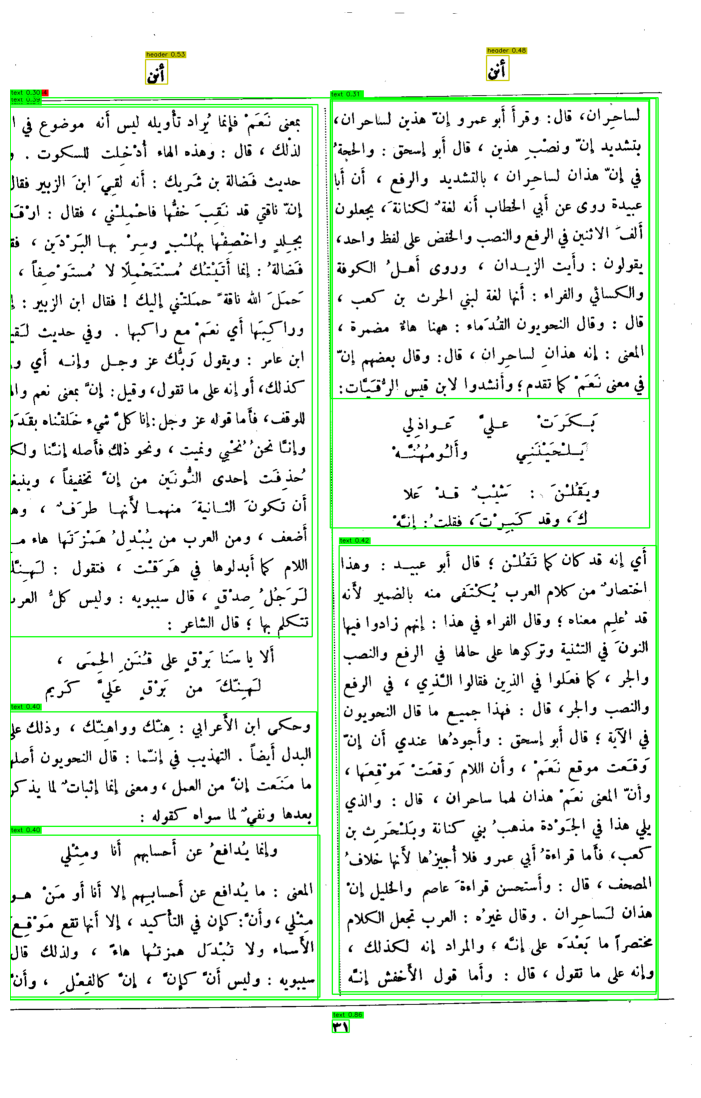

Page 2 layout elements: 6


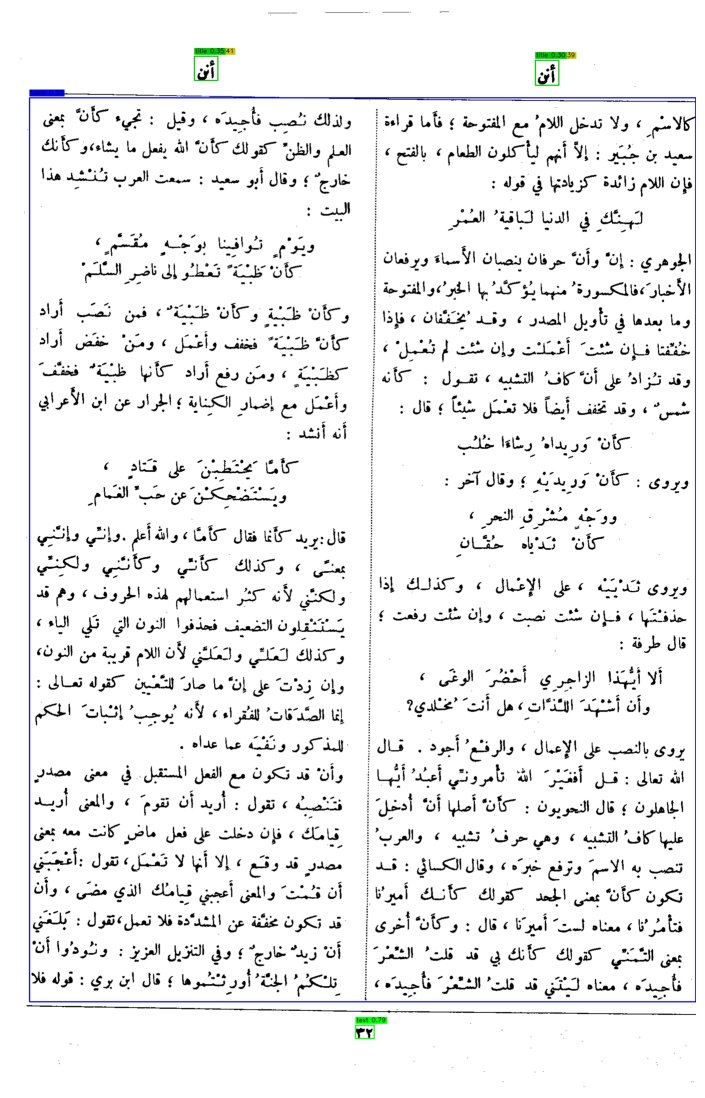

Page 3 layout elements: 5


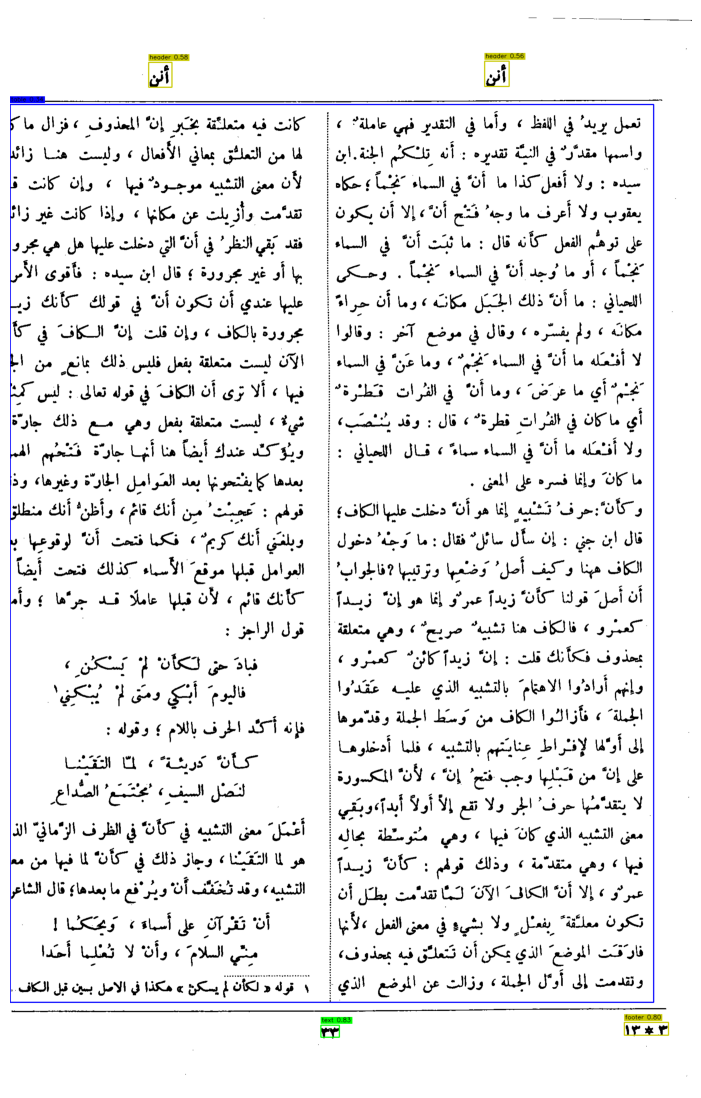

Page 4 layout elements: 5


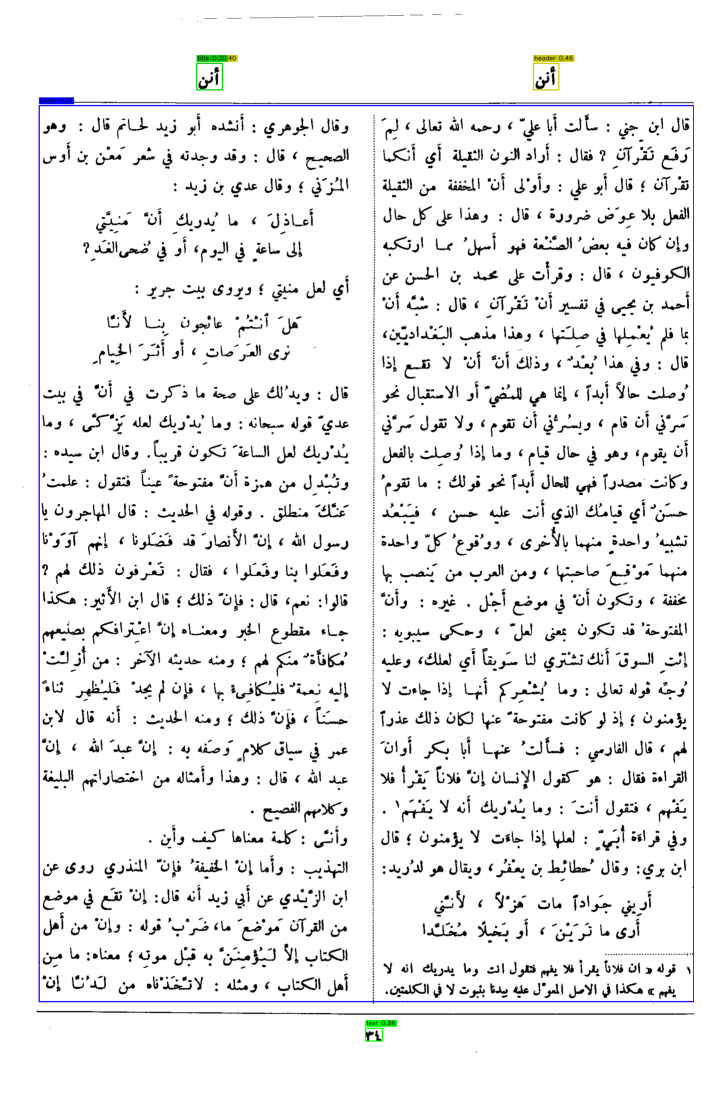

Page 5 layout elements: 4


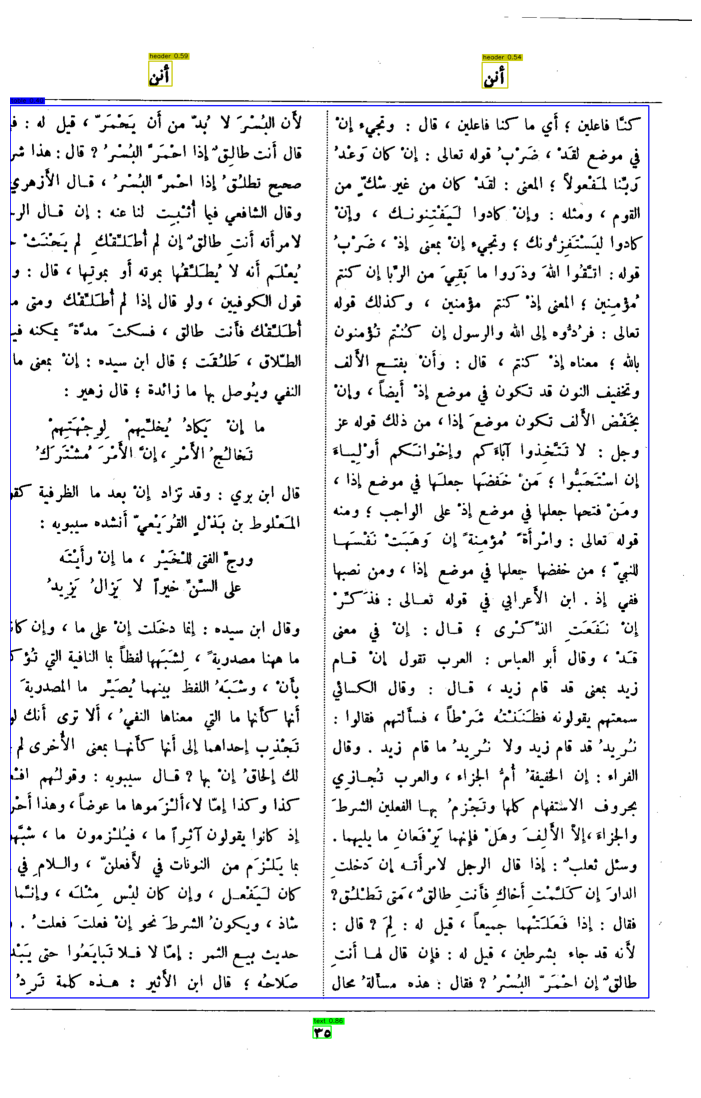

Page 6 layout elements: 4


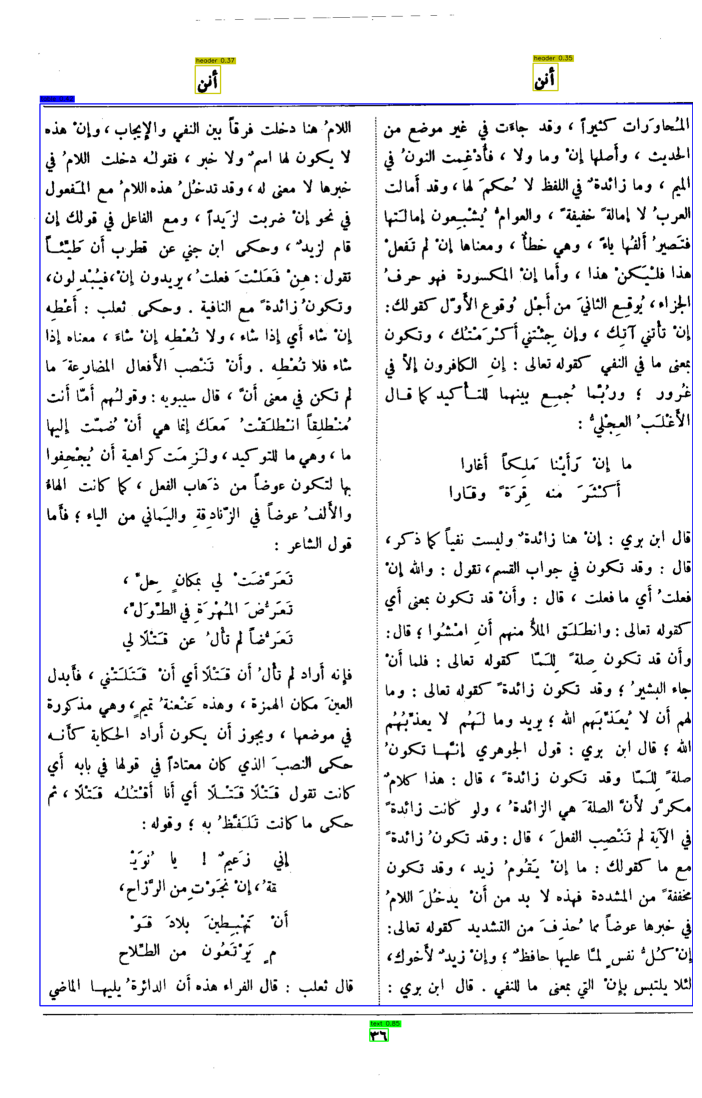

Page 7 layout elements: 15


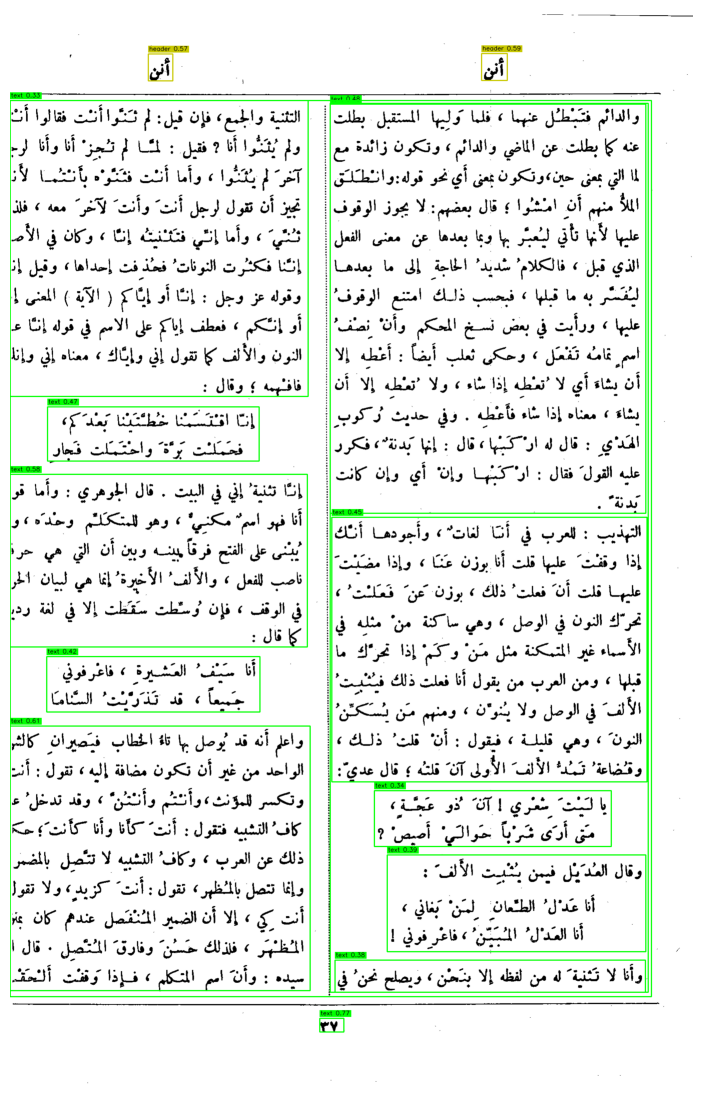

Page 8 layout elements: 6


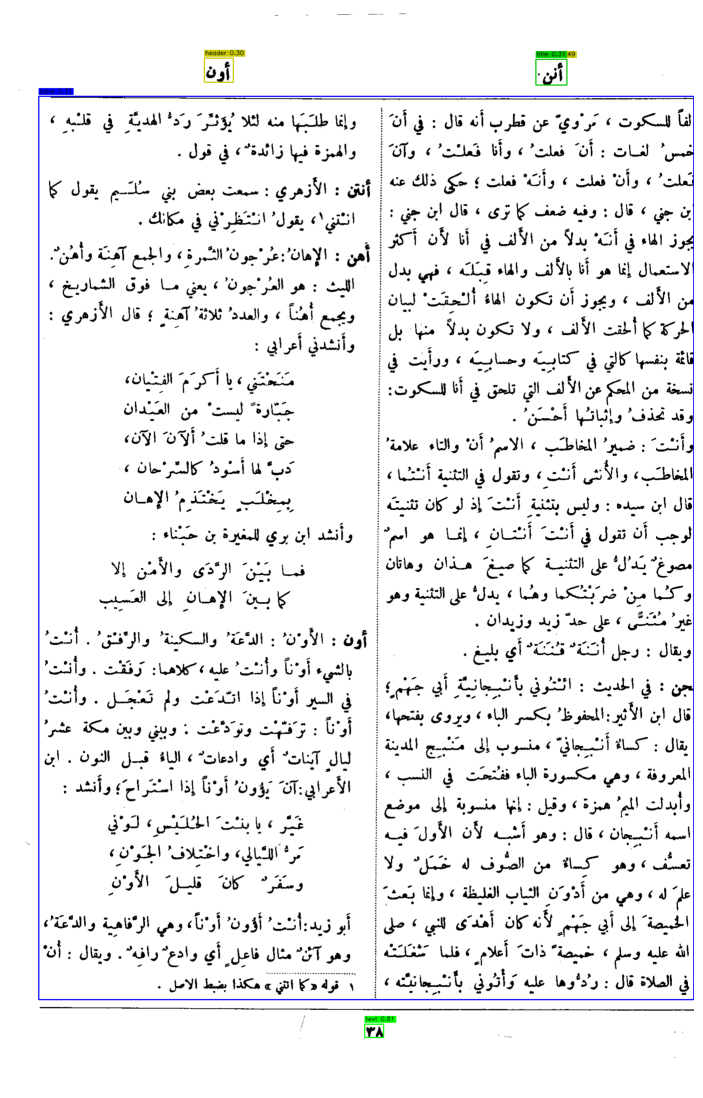

Page 9 layout elements: 12


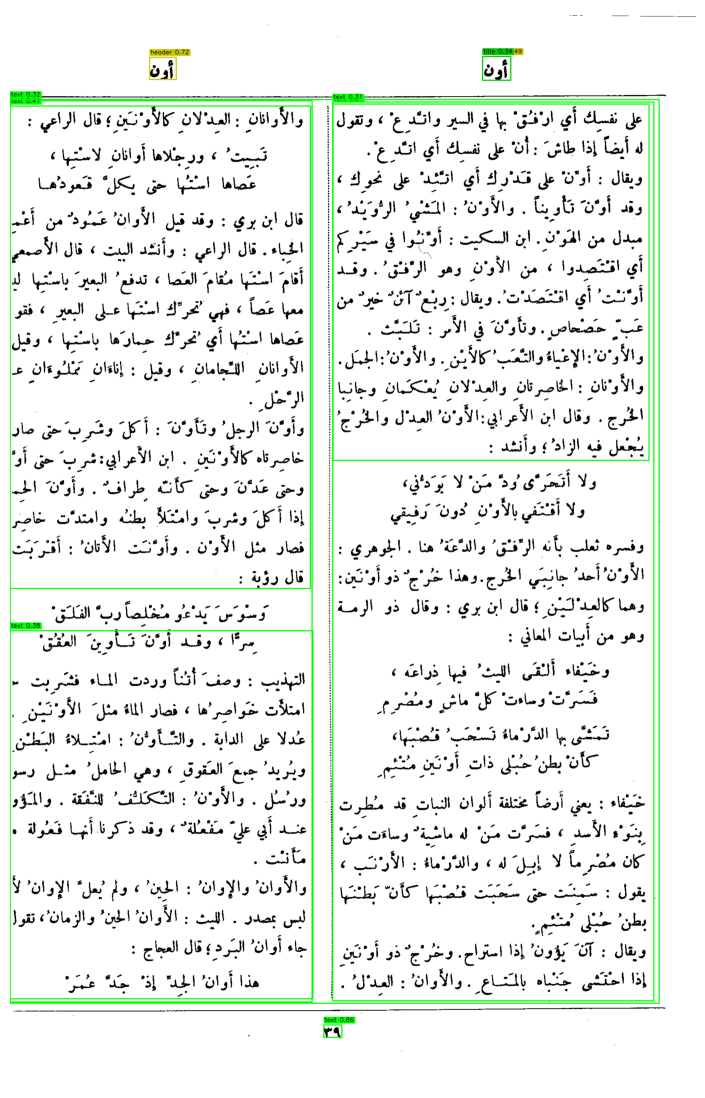

Page 10 layout elements: 7


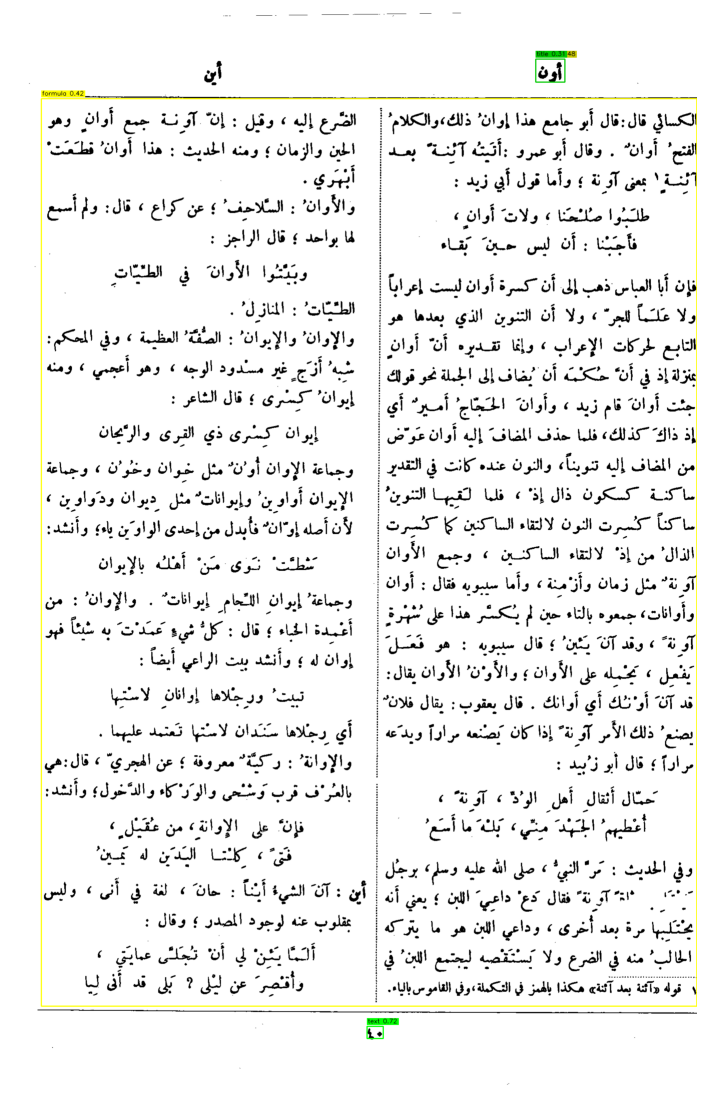

Page 11 layout elements: 5


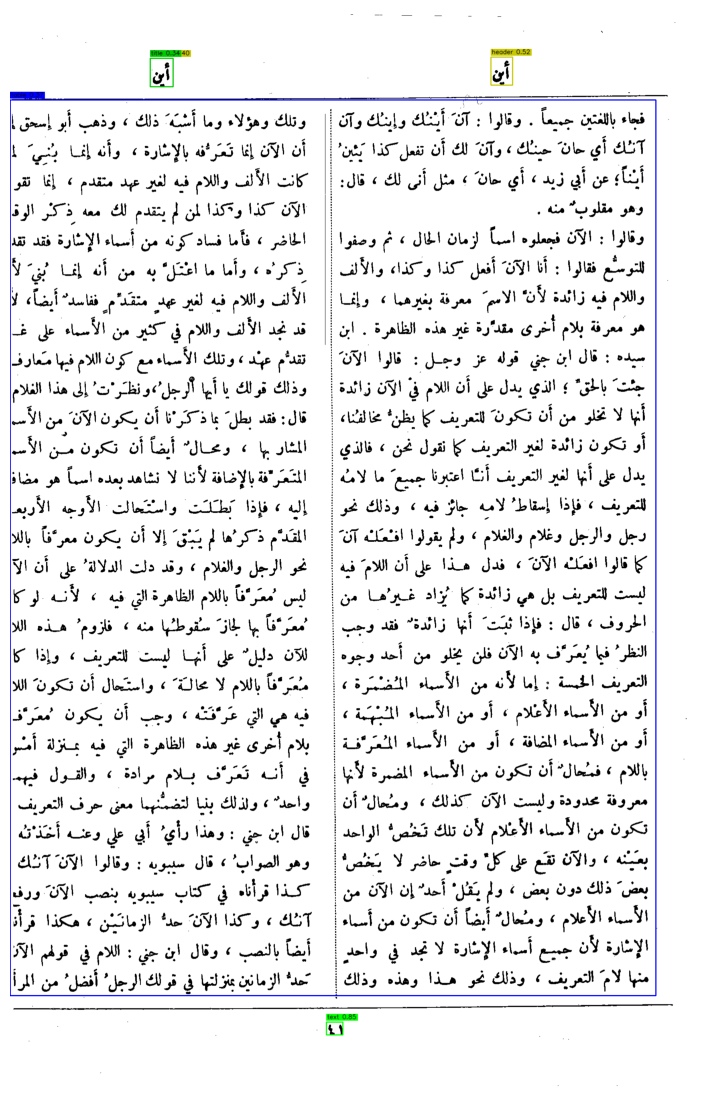

Page 12 layout elements: 2


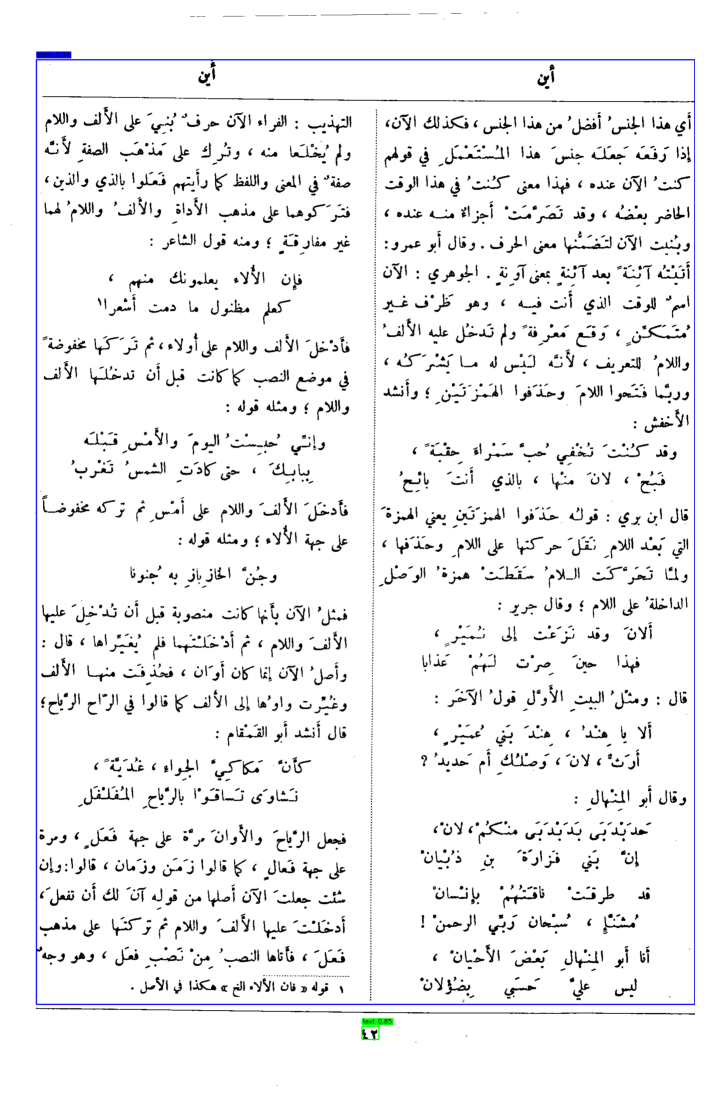

Page 13 layout elements: 13


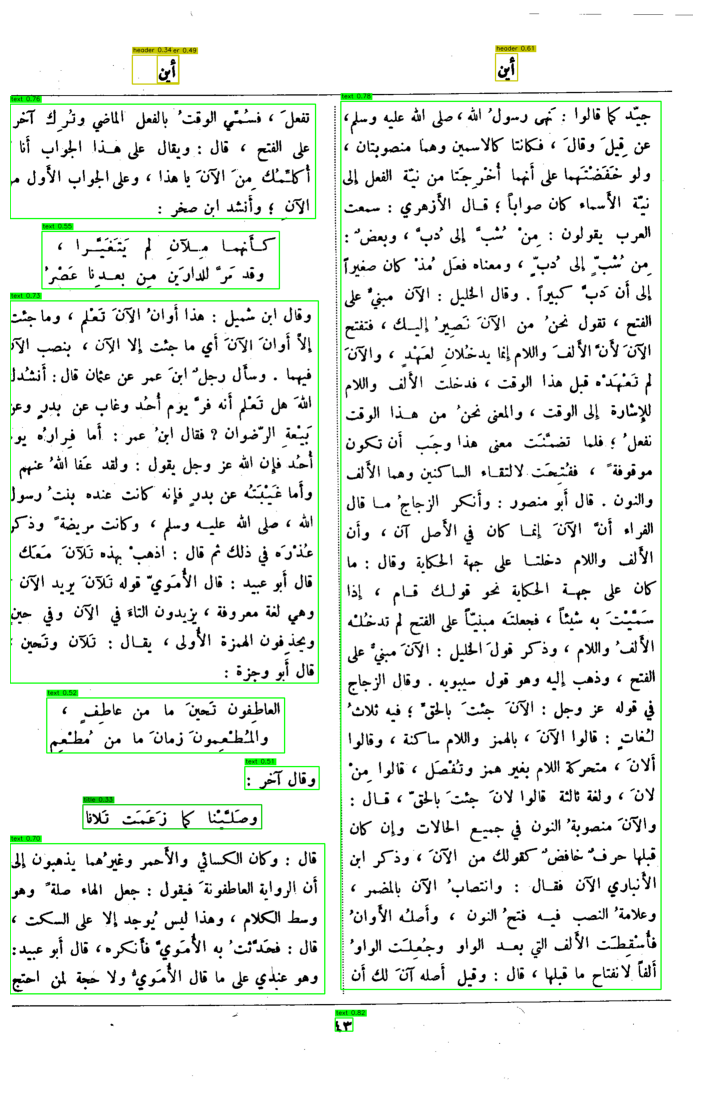

Page 14 layout elements: 6


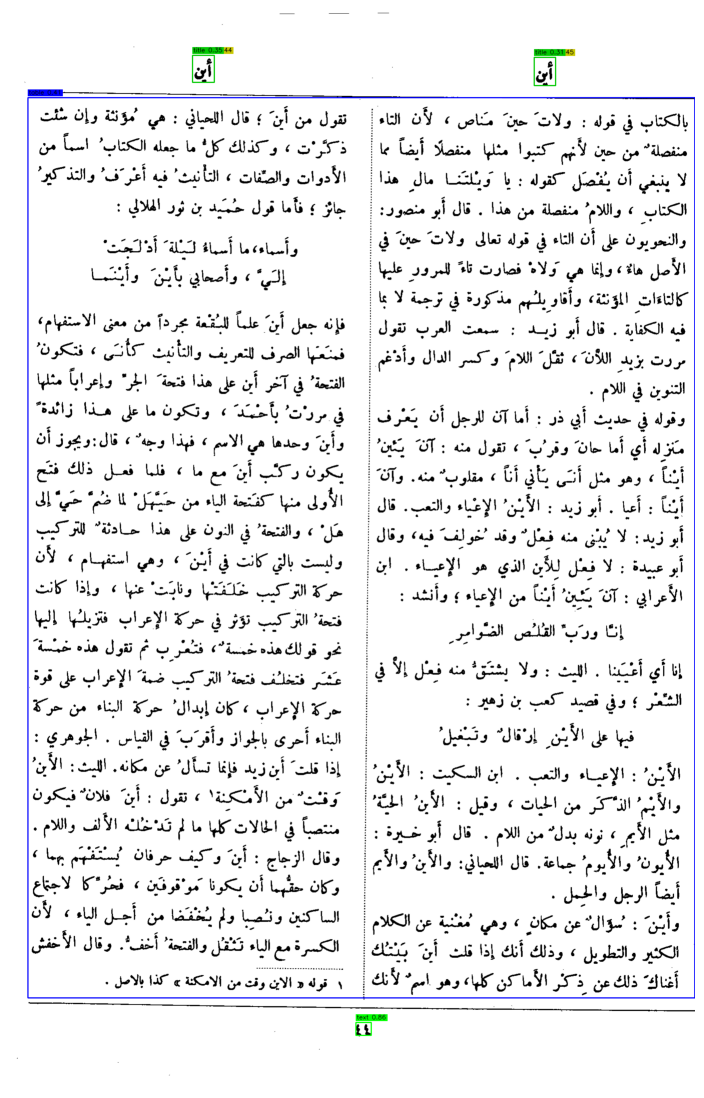

Page 15 layout elements: 4


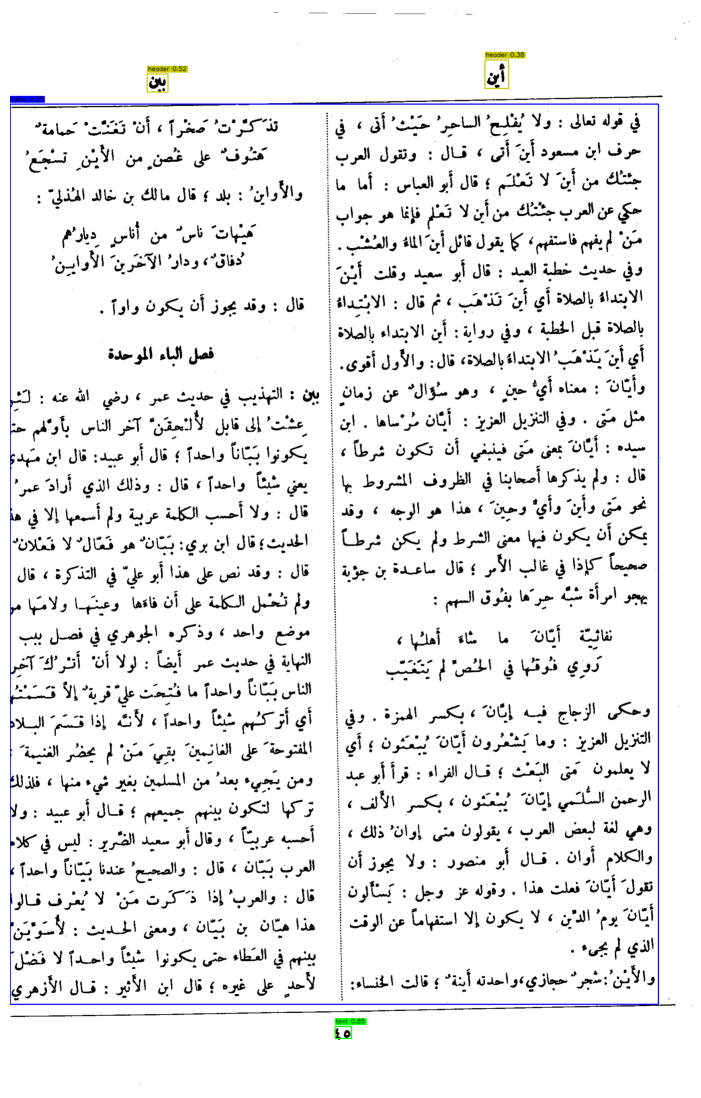

Page 16 layout elements: 12


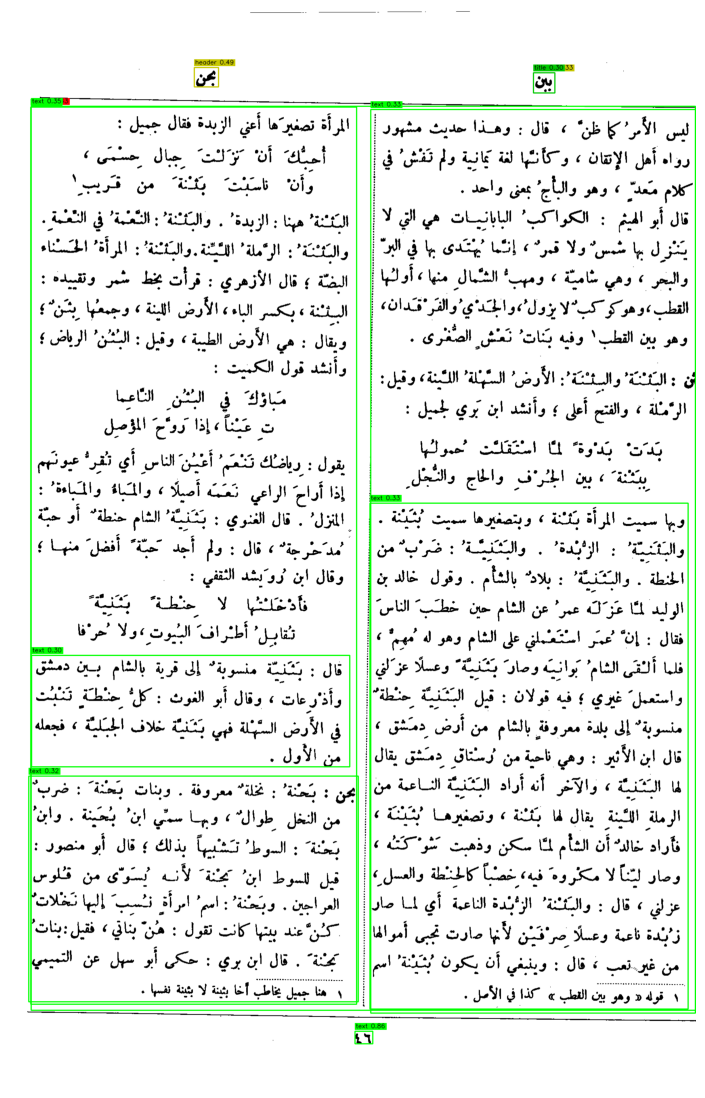

Page 17 layout elements: 8


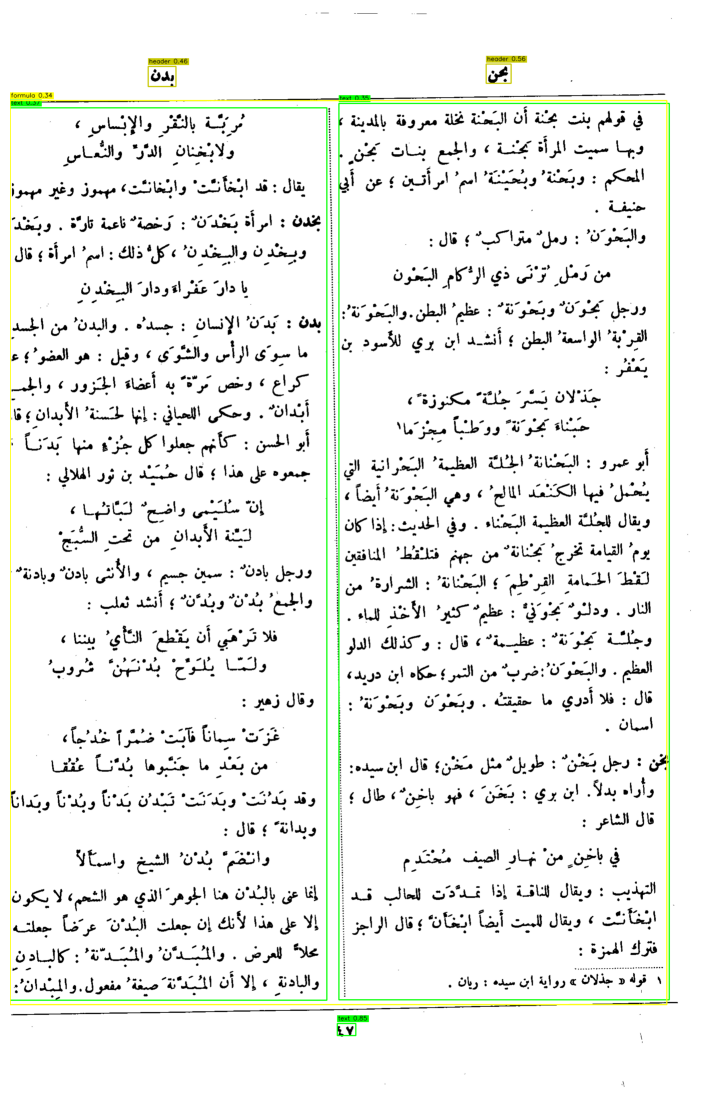

Page 18 layout elements: 2


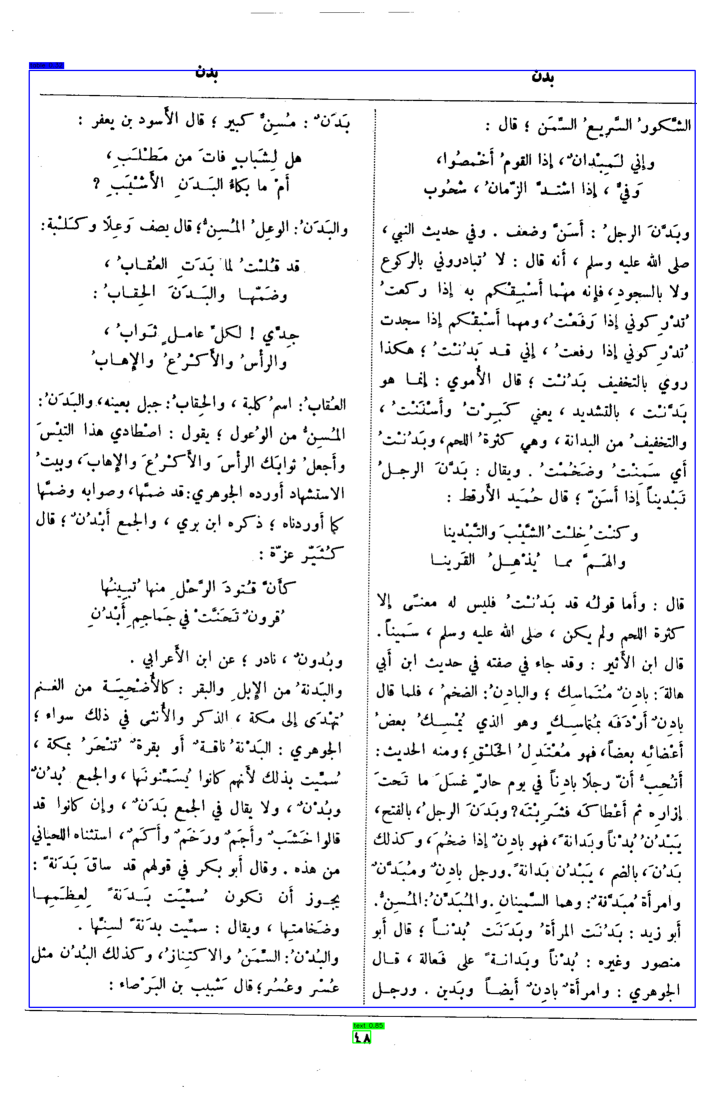

Page 19 layout elements: 7


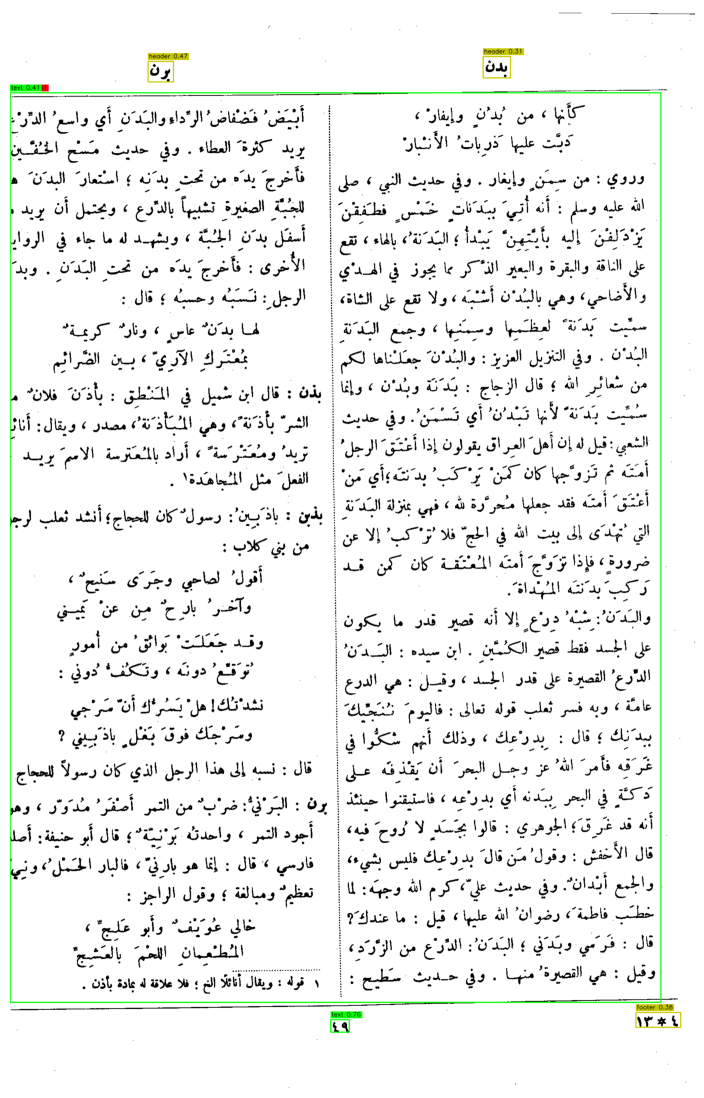

Page 20 layout elements: 6


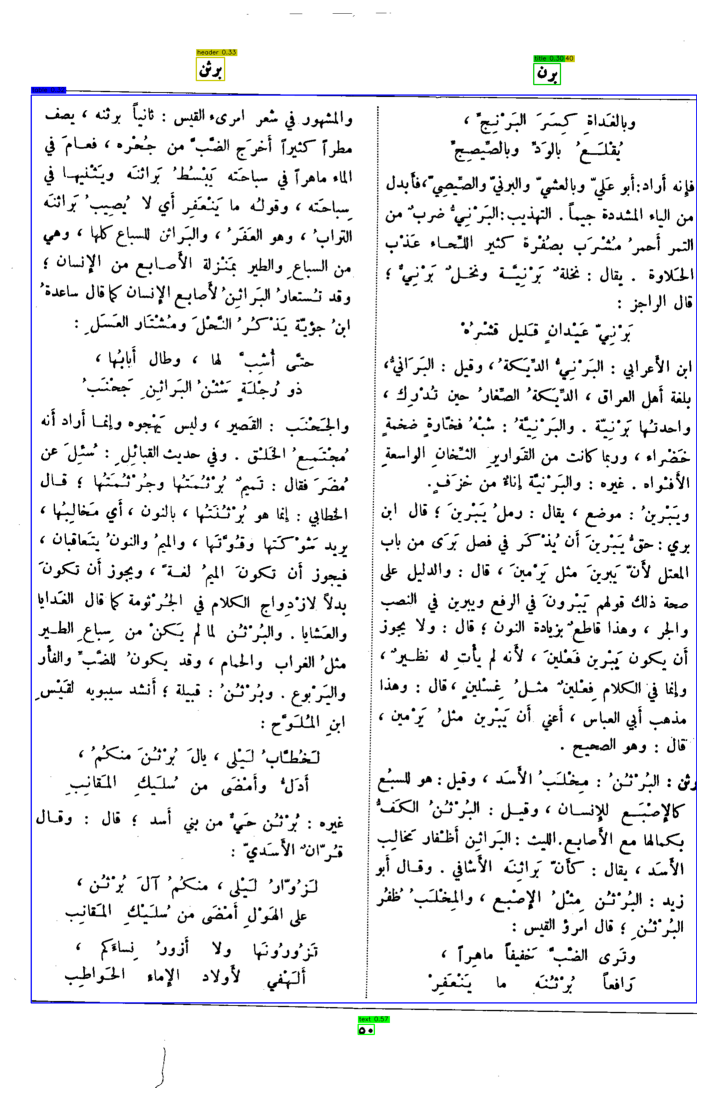

In [15]:
# ...existing code...
import matplotlib.pyplot as plt
import cv2
import numpy as np
from io import BytesIO

def draw_layout_on_image(pil_image, elements, thickness=2, save_path=None):
    img_rgb = pil_image.convert("RGB")
    W, H = img_rgb.size
    arr = np.array(img_rgb)  # RGB, dtype usually uint8
    # convert to BGR and make contiguous uint8 (required by OpenCV)
    img = np.ascontiguousarray(arr[:, :, ::-1])
    if img.dtype != np.uint8:
        img = img.astype(np.uint8)

    def to_pixel_coords(bbox):
        if not bbox or len(bbox) < 4:
            return None
        x1, y1, x2, y2 = bbox[:4]
        # normalized -> pixels
        if 0.0 <= x1 <= 1.0 and 0.0 <= x2 <= 1.0 and 0.0 <= y1 <= 1.0 and 0.0 <= y2 <= 1.0:
            x1 = int(x1 * W); x2 = int(x2 * W)
            y1 = int(y1 * H); y2 = int(y2 * H)
        else:
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        # clamp
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(W - 1, x2), min(H - 1, y2)
        return x1, y1, x2, y2

    color_map = {
        "text": (0, 255, 0),
        "title": (0, 200, 0),
        "table": (255, 0, 0),
        "image": (0, 0, 255),
        "formula": (0, 255, 255),
    }

    for elem in elements:
        bbox = getattr(elem, "bbox", None) or []
        coords = to_pixel_coords(bbox)
        if coords is None:
            continue
        x1, y1, x2, y2 = coords
        c = color_map.get(getattr(elem, "type", "text"), (0, 200, 200))
        # ensure img is writable contiguous uint8
        try:
            cv2.rectangle(img, (x1, y1), (x2, y2), c, thickness)
        except Exception as e:
            print("cv2.rectangle error:", e, "coords:", (x1,y1,x2,y2), "img.shape:", img.shape, "dtype:", img.dtype)
            continue

        label = getattr(elem, "type", "")
        conf = getattr(elem, "confidence", None)
        if conf is not None:
            try:
                label = f"{label} {conf:.2f}"
            except Exception:
                label = f"{label} {conf}"
        (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        txt_y = max(0, y1 - 6)
        cv2.rectangle(img, (x1, txt_y - th - 2), (x1 + tw + 4, txt_y + 2), c, -1)
        cv2.putText(img, label, (x1 + 2, txt_y - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

    img_rgb_out = img[:, :, ::-1]
    plt.figure(figsize=(10, 14))
    plt.imshow(img_rgb_out)
    plt.axis("off")
    plt.show()

    if save_path:
        cv2.imwrite(save_path, img)

# Run detection and draw boxes for pages
layout_detector = PaddleLayoutDetector()
for page_num, page_image in enumerate(pages, start=1):
    buf = BytesIO()
    page_image.save(buf, format="PNG")
    img_bytes = buf.getvalue()

    layout = layout_detector.detect_layout(img_bytes, page_number=page_num)
    print(f"Page {page_num} layout elements: {len(layout.elements)}")
    draw_layout_on_image(page_image, layout.elements, thickness=2, save_path=None)
# ...existing code...